## Signal codification and decodification

This code creates an input signal called tonemistery that  has to be decoded to automatically determine its frequency and time content. The routine tonegen(digitos) receives as inputs a five element vector and outputs the signal tonemistery that contains a frequency coded version of the input vector in addition to the interference signal and the noise. There is a second input to this routine tonegen(digitos,escala). The escala parameter indicates the  scalar that multiplies the interference additive signal plus the noise. The tonemistery signal must contain:

|Digit|Frecuency(Hz)|
|---|---|
|0|200|
|1|700|
|2|1200|
|3|1700|
|4|2200|
|5|2700|
|6|3200|
|7|3700|
|8|4200|
|9|4700|
Table 1

(a) A sucesion of short pulses with constant frequencies. The desired signal codifies a sequence of digits using different frequencies to represent the individual digits according to Table 1. In this way, the signal changes its frequency in 20 ms lapse of time and it is 100 ms long. For instance, the digit sequence 7-3-4-1-9 consists of a sine signals with frequencies 3700 Hz, 1700 Hz, 2200 Hz, 700 Hz, and 4700 Hz. The sampling  rate frequency is 12 KHz.


(b) The second component  is an interference signal with a higher amplitude than the frequency coded signal.
The frequency of this interference signal changes with time. The peak value of this signal is five times than the amplitude of the coded signal. The interference signal must be a chirp signal.

(c)  The third component is additive white Gaussian noise with mean equal to zero and variance equal to 4 \% of the signal amplitude. Even thought there is  noise in  the signal, it can be decoded. This noise is added to make the problem more 'real'.






In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp
from scipy import signal


In [2]:
def TDFdirecta(x):
    
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X.imag, X.real, abs(X), np.angle(X.imag/X.real)

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [14]:
def tonegen(digitos, fs = 12000,  escala = 1):
    
    n_digitos = len(digitos) 
    
    ts = 1/fs
    
    signal_time = 0.02    
    t = np.arange(0, signal_time*n_digitos, ts) # signal duration of 20ms
         
    n_muestras = int(signal_time/ts)
    
    tonemisterio = np.zeros(n_digitos * n_muestras) # total length of the misterio signal
    
    # First component of the sine signals.
    
    for i in range(len(digitos)):
        
        f = f_digitos[digitos[i]]
        
        a_interval = n_muestras*i
        b_interval = (n_muestras*i) + n_muestras
        tonemisterio[a_interval : b_interval] += escala*np.sin(2*np.pi*f*t[a_interval : b_interval])
    
    # Second component is the interference signal.
    
    f0 = np.random.randint(1, int(fs/3))
    f1 = np.random.randint(1, int(fs/3))
    
    interferencia = chirp(t, f0 = f0, f1 = f1, t1 = t[int(len(t)/2)], method='linear')
    
    # Third  component is the white additive Gaussian noise.
    varianza_ruido = 0.04*5*escala # 4% of the amplitude of the interference signal
    ruido = np.random.normal(0, varianza_ruido, n_digitos * n_muestras)
    
    return tonemisterio, interferencia, ruido, t
    
    

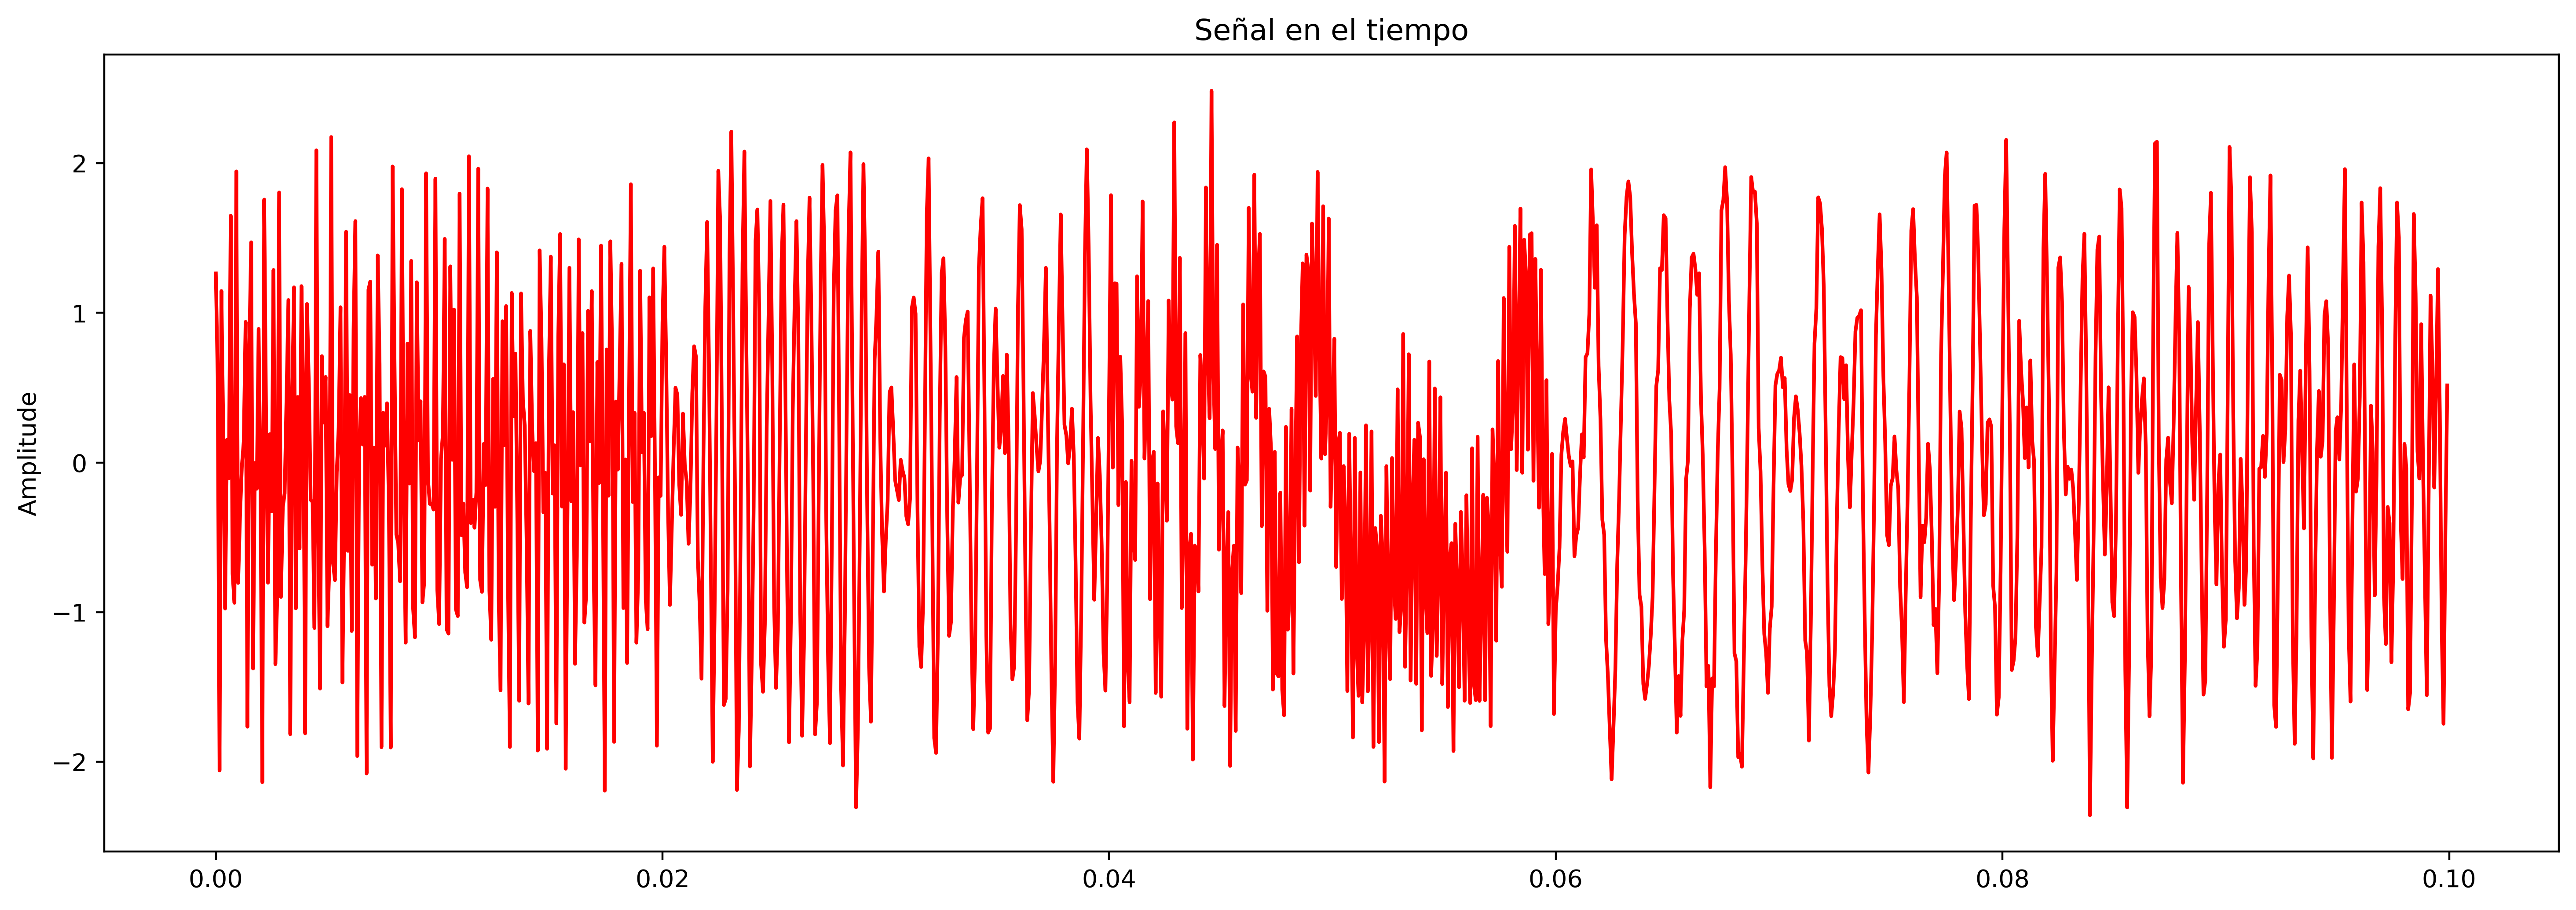

[Text(0, 0.5, 'Frequency (Hz)'), Text(0.5, 0, 'Time (s)')]

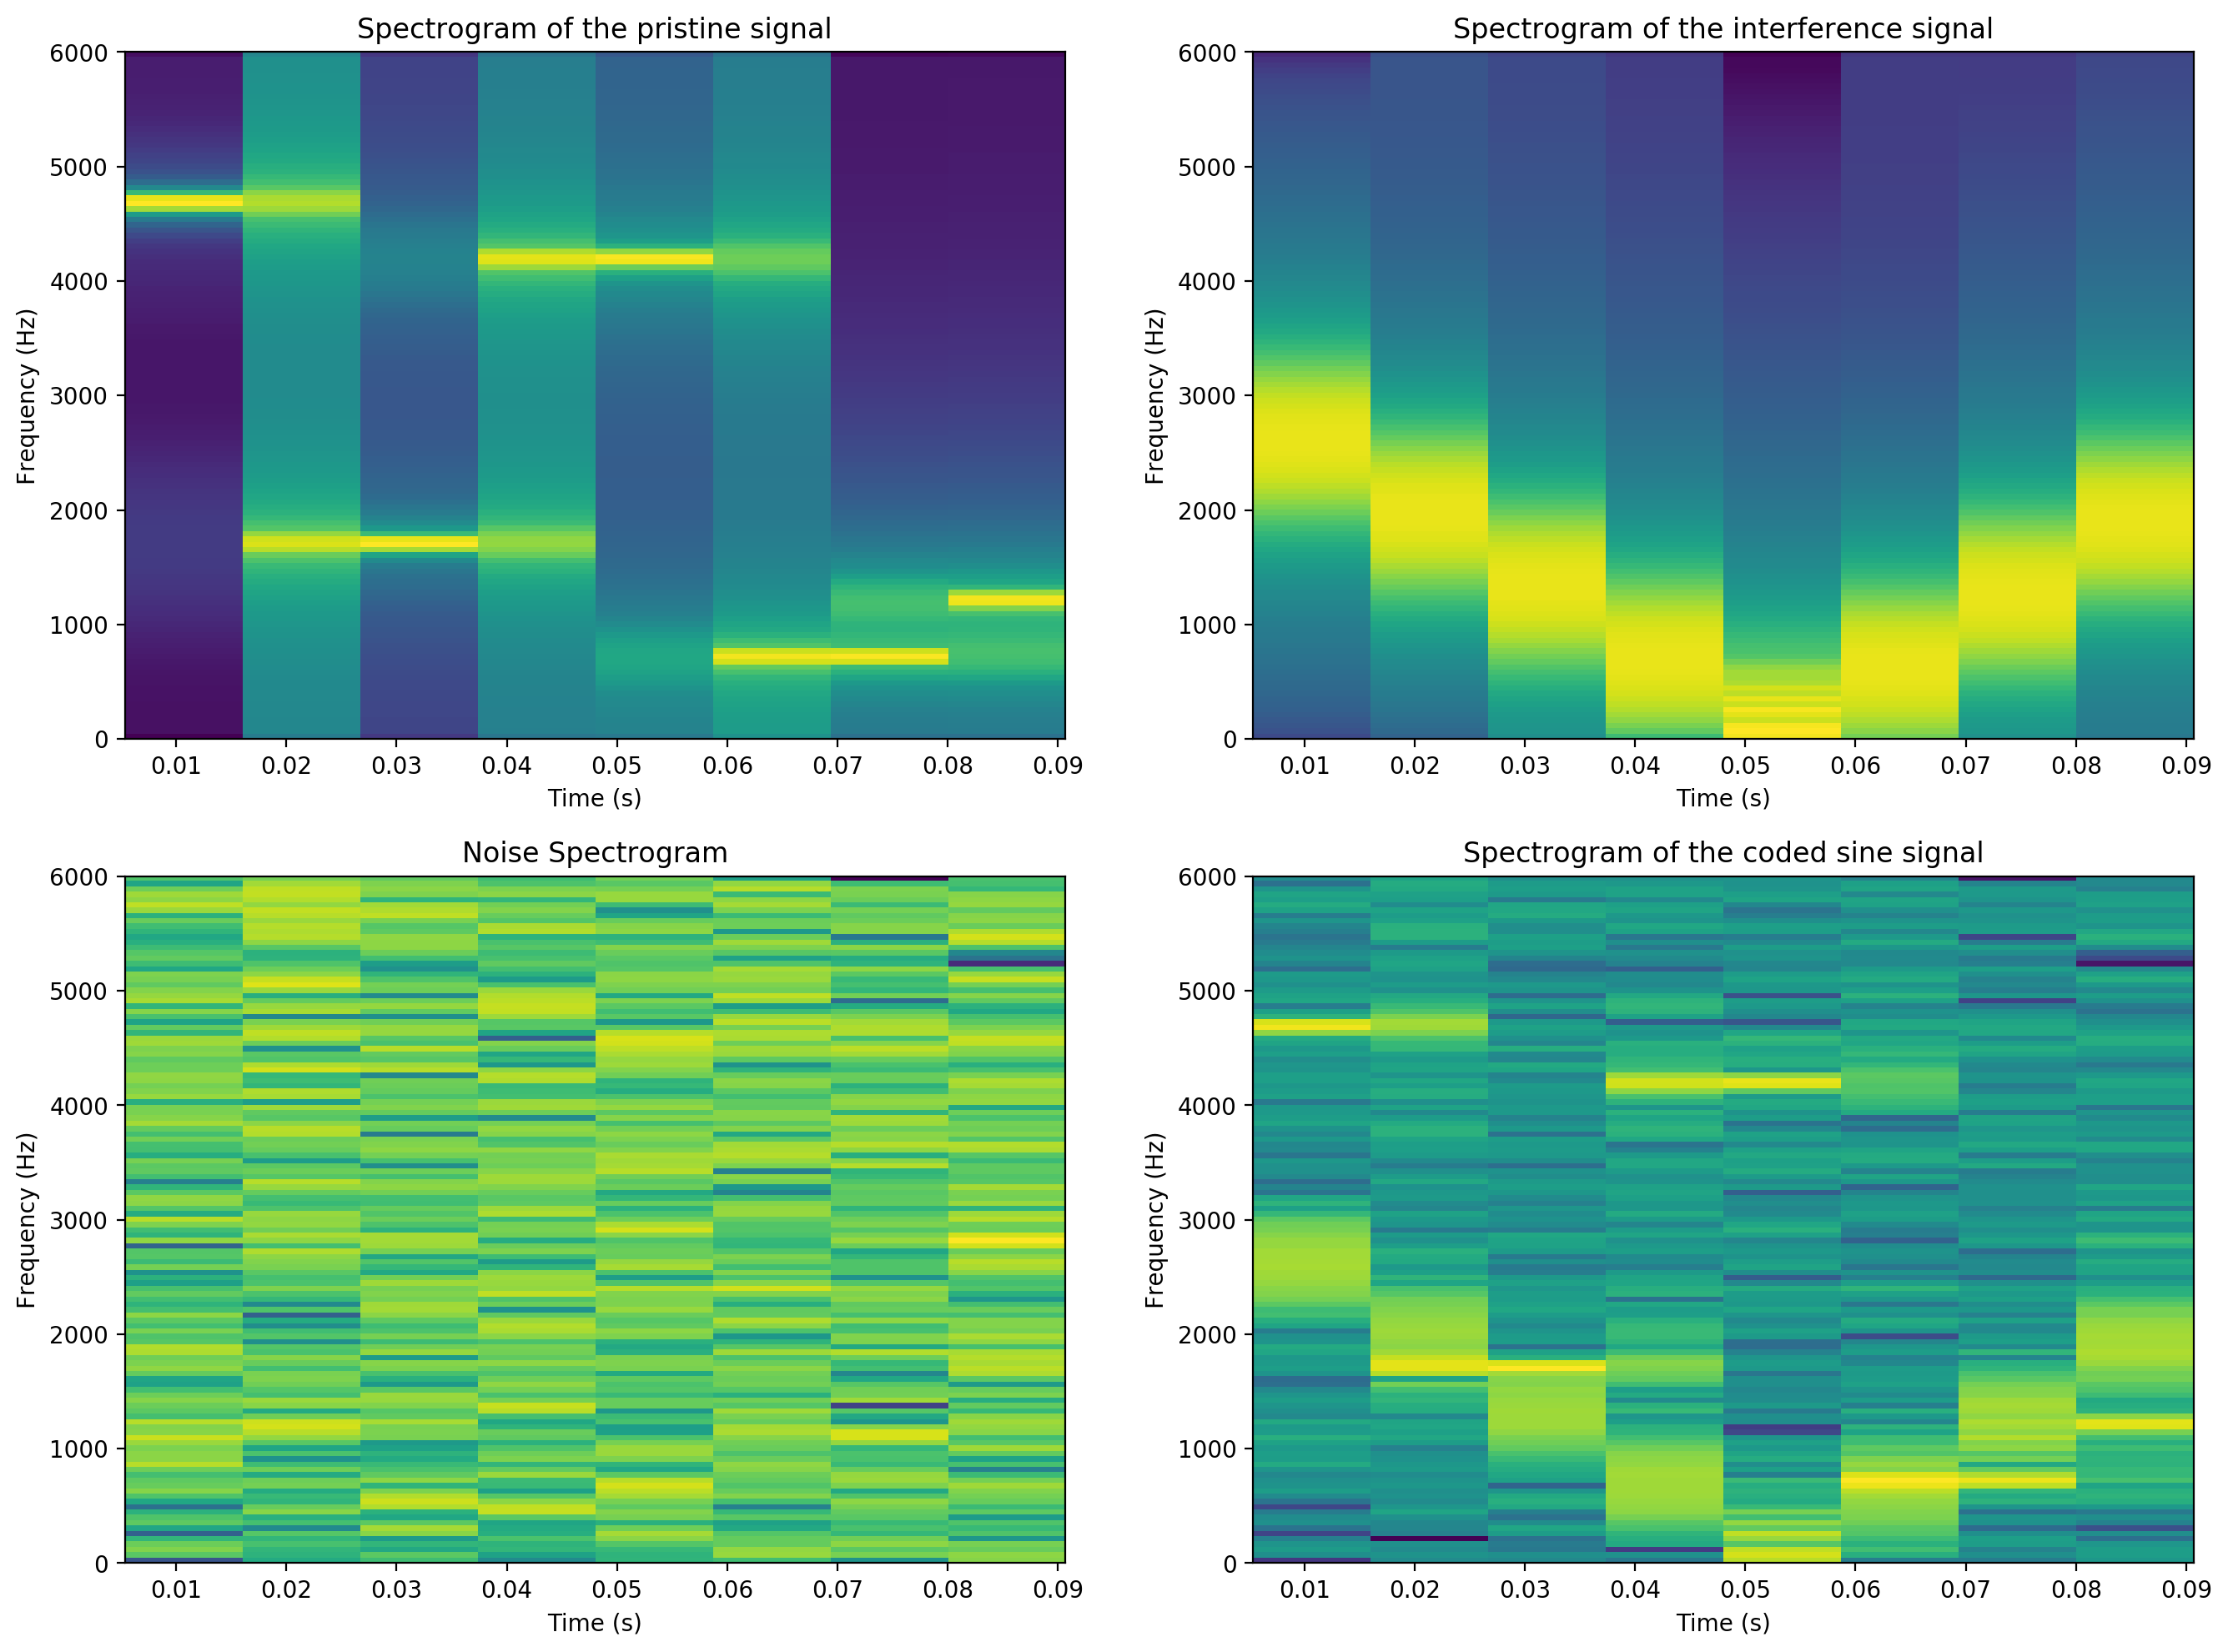

In [8]:
fs = 12000.0    # fs = 12 KHz


f_digitos = [200, 700, 1200, 1700, 2200, 2700, 3200, 3700, 4200, 4700]

#digitos=[3, 9, 8, 1, 2]
digitos=[9, 3, 8, 1, 2]

n_digitos = len(digitos) 
    
tonemisterio, interferencia, ruido, t = tonegen(digitos, fs)

codificacion = tonemisterio + interferencia + ruido

plt.figure(figsize = (18, 6), dpi = 400)
plt.plot(t, codificacion, 'r')
plt.ylabel('Amplitude')
plt.title('Señal en el tiempo')

plt.show()

fig, ax = plt.subplots(2, 2, figsize=(16, 12), dpi = 200)

_, _, _, _ = ax[0,0].specgram(tonemisterio, Fs=fs, aspect = 'auto')
ax[0,0].set_title('Spectrogram of the pristine signal')
ax[0,0].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

_, _, _, _ = ax[0,1].specgram(interferencia, Fs=fs, aspect='auto')
ax[0,1].set_title('Spectrogram of the interference signal')
ax[0,1].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

_, _, _, _ = ax[1,0].specgram(ruido, Fs=fs, aspect='auto')
ax[1,0].set_title('Noise Spectrogram')
ax[1,0].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

_, _, _, _ = ax[1,1].specgram(codificacion, Fs=fs, aspect = 'auto')
ax[1,1].set_title('Spectrogram of the coded sine signal')
ax[1,1].set(xlabel='Time (s)', ylabel='Frequency (Hz)')

/Users/hernan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


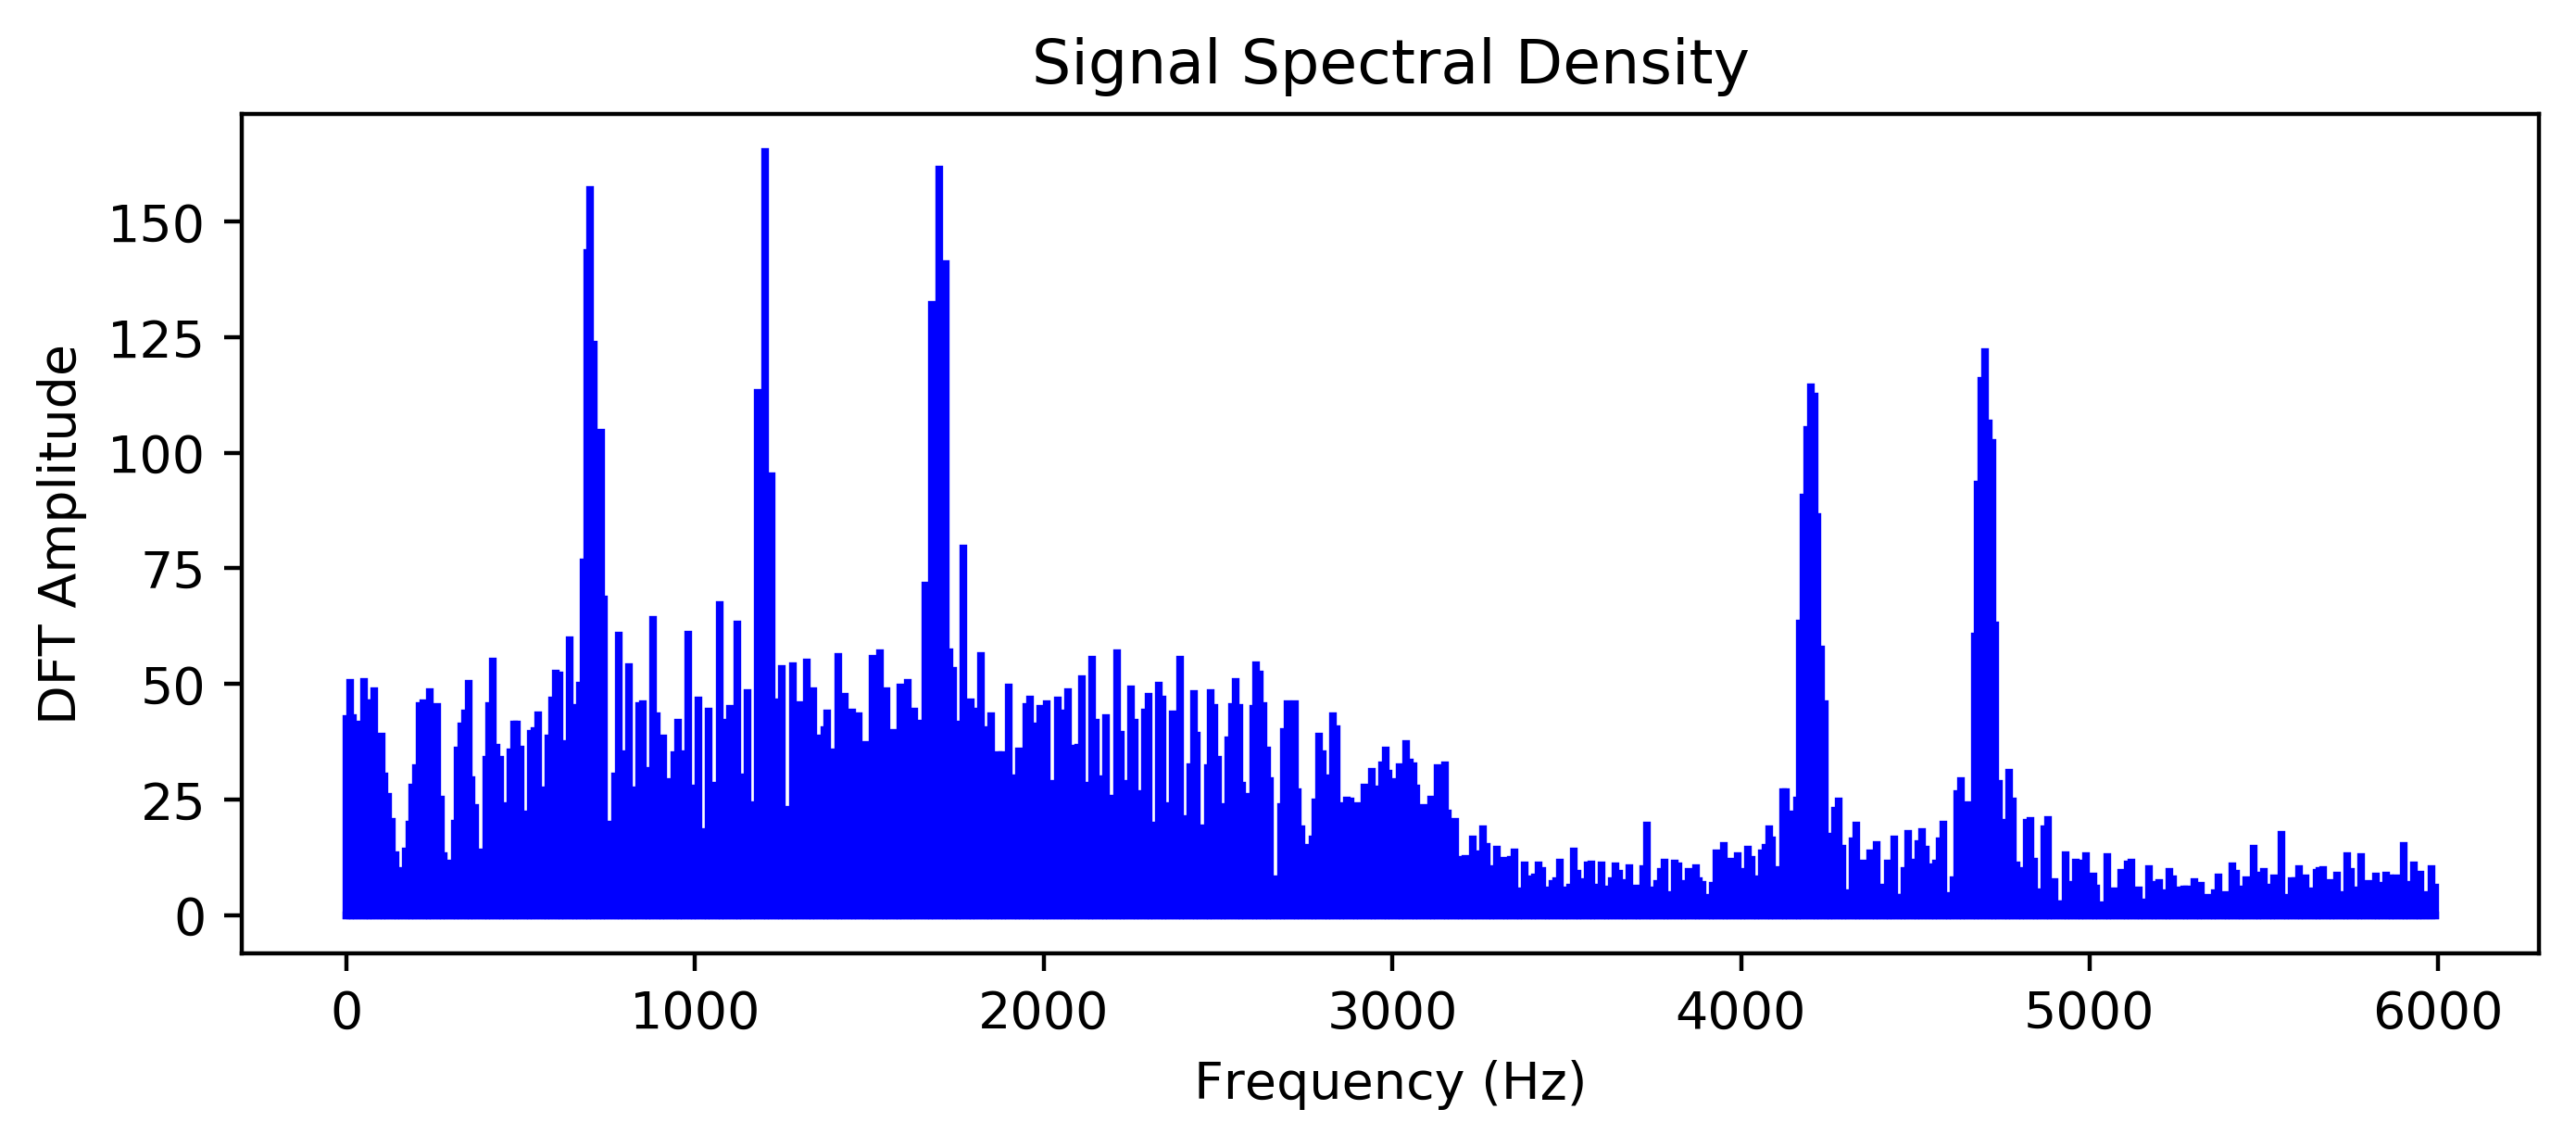

In [11]:
[IM, RE, Mag, Fase] = TDFdirecta(codificacion)

N = len(Mag)
n = np.arange(N)
T = N/fs
freq = n/T 

plt.figure(figsize = (8, 3), dpi = 400)
plt.stem(freq[0:int(N/2)], Mag[0:int(N/2)], 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('DFT Amplitude')
plt.title('Signal Spectral Density')
plt.show()


In [15]:
f, t, Sxx = signal.spectrogram(tonemisterio, fs= fs)
F_peaks = f[np.argmax(Sxx, axis=0)]

decode_message = np.zeros(len(F_peaks))


for i in range(len(F_peaks)):
    
    _, decode_message[i] = find_nearest(f_digitos, F_peaks[i])


print('The decoded message in the tonemistery signal is: ', decode_message.astype(int))

The decoded message in the tonemistery signal is:  [9 3 8 1 2]
